In [8]:
import torch
import torch.nn as nn
from dataset import get_transforms, CT_Dataset
from models import UNet
import os
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [3]:
csv_dir = "/home/anees.hashmi/Desktop/labs/hc701_assignment_3/csv_liver_only"
model_dir = "/home/anees.hashmi/Desktop/labs/hc701_assignment_3/models"
model_name = "unet_mobilenet_dice_liver_only"
device = "cuda"
num_workers = 24
batch_size = 1
num_classes = 2
model_path ="/home/anees.hashmi/Desktop/labs/hc701_assignment_3/models/"
result_dir ="./results/"
backbone = "mobilenet_v2"
checkpoint = None

In [4]:
if not checkpoint:
    all_chckpoints = [i[:-5] for i in sorted(os.listdir(f"{model_path}{model_name}"))]
    checkpoint = f"""{["-".join(i) for i in sorted([i.split('-') for i in all_chckpoints], key=lambda x: x[2])][-1]}.ckpt"""

checkpoint

'unet-47-0.8147713441576222.ckpt'

In [5]:
_, test_transforms = get_transforms()
include_background = True if num_classes == 3 else False
test_dataset = CT_Dataset(csv_dir = csv_dir, image_set="test", transforms= test_transforms, include_background=include_background)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size= batch_size, shuffle=True, num_workers= num_workers)



In [6]:
# train_dataset = CT_Dataset(csv_dir = args.csv_dir, image_set="train", transforms= train_transforms)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)

# Tensorboard
# uploade 10 sample images to tensorboard


# Load the model


# model = UNet(n_channels=3, n_classes=args.num_classes) # inlcluding background
model = smp.Unet(
    encoder_name=backbone,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=num_classes,                      # model output channels (number of classes in your dataset)
)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, model_name, checkpoint)))

model.eval();


In [7]:
sig = nn.Sigmoid()

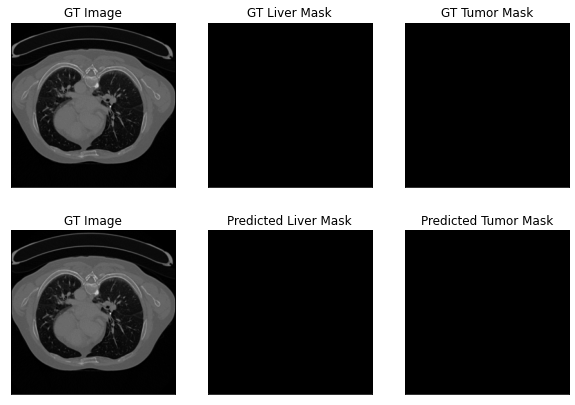

In [63]:
sample = next(iter(test_loader))
sample[0].shape, sample[1].shape
preds = sig(model(sample[0].to(device)))

plt.figure(figsize=(10,7))

plt.subplot(2,3,1)
plt.imshow(sample[0][0,0,:,:], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("GT Image")
plt.subplot(2,3,2)
plt.imshow(sample[1][0,0,:,:], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("GT Liver Mask")
plt.subplot(2,3,3)
plt.imshow(sample[1][0,1,:,:], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("GT Tumor Mask")
# plt.imshow(pred[])



plt.subplot(2,3,4)
plt.imshow(sample[0][0,0,:,:], cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("GT Image")
plt.subplot(2,3,5)
plt.imshow(preds[0,0,:,:].detach().cpu().numpy(), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("Predicted Liver Mask")
plt.subplot(2,3,6)
plt.imshow(preds[0,1,:,:].detach().cpu().numpy(), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("Predicted Tumor Mask")

plt.show()